[Google Colaboratory Variant](https://colab.research.google.com/drive/1sDO3S-oPGgdgxwzkBFFousJa6dYexd7z?)

In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Orbitron&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Orbitron; color:#ff1155;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,time,copy,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils,models
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
pl.ion() 

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders2[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
@register_line_magic
def show_examples(data):
    dataiter=iter(dataloaders[data])
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:5]))
    print('^'.join('%11s'%classes[labels[j]] 
                   for j in range(5)),end='^')

In [6]:
dhtml('Data')

In [7]:
img_size=32
classes=('plane','car','bird','cat','deer',
          'dog','frog','horse','ship','truck')
random_seed=12; batch_size=256
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
train_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size), 
             'valid':tdl(dataset=valid,shuffle=True, 
                         batch_size=batch_size),
             'test':tdl(dataset=test,shuffle=True, 
                        batch_size=batch_size)}

Extracting data/cifar-10-python.tar.gz to data


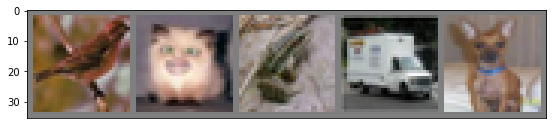


       bird^        cat^       frog^      truck^        dog^

In [8]:
%show_examples test

In [9]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')
x=x.reshape(-1,3,img_size,img_size)/255
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
dataloaders2={'train':tdl(dataset=train2,shuffle=True, 
                          batch_size=batch_size), 
              'valid':tdl(dataset=valid2,shuffle=True, 
                          batch_size=batch_size),
              'test':tdl(dataset=test2,shuffle=True, 
                         batch_size=batch_size)}

['backgrounds', 'images', 'labels']
0.5900519 0.1395963


Image dimensions: torch.Size([256, 3, 32, 32])
Label dimensions: torch.Size([256])


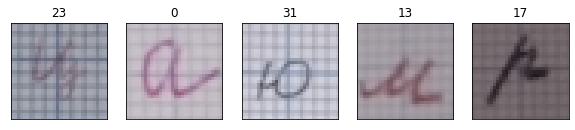

In [10]:
%display_examples valid

In [11]:
dhtml('Model Loading and Training')

In [12]:
def train_model(model,dataloaders,criterion,optimizer,
                scheduler,num_epochs):
    start=time.time(); best_acc=0.
    best_model_wts=copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train': model.train()
            else: model.eval()
            running_loss=0.; running_corrects=0
            for images,labels in dataloaders[phase]:
                images=images.to(dev)
                labels=labels.to(dev).long()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(images)
                    _, preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    if phase=='train':
                        loss.backward(); optimizer.step()
                running_loss+=loss.item()*images.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase=='train': scheduler.step()
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            print('phase: {} loss: {:.4f} acc: {:.4f}'\
                  .format(phase,epoch_loss,epoch_acc))
            if phase=='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
    time_elapsed=time.time()-start
    print('training time: {:.0f}m {:.0f}s'\
          .format(time_elapsed//60,time_elapsed%60))
    print('best valid acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [13]:
num_classes=10; learning_rate=.0001
dataset_sizes={'train':44000,'valid':6000}
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=tnn.Linear(num_ftrs,num_classes)
model_ft=model_ft.to(dev)
criterion=tnn.CrossEntropyLoss()
optimizer_ft=torch.optim.Adam(model_ft.parameters(),
                              lr=learning_rate)
exp_lr_scheduler=torch.optim.lr_scheduler\
.StepLR(optimizer_ft,step_size=5,gamma=.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [14]:
model_ft=train_model(model_ft,dataloaders,criterion,
                     optimizer_ft,exp_lr_scheduler,
                     num_epochs=25)

Epoch 1/25
----------
phase: train loss: 1.1557 acc: 0.6011
phase: valid loss: 0.7826 acc: 0.7370
Epoch 2/25
----------
phase: train loss: 0.5974 acc: 0.7950
phase: valid loss: 0.6742 acc: 0.7688
Epoch 3/25
----------
phase: train loss: 0.3719 acc: 0.8748
phase: valid loss: 0.6860 acc: 0.7773
Epoch 4/25
----------
phase: train loss: 0.2116 acc: 0.9318
phase: valid loss: 0.7242 acc: 0.7825
Epoch 5/25
----------
phase: train loss: 0.1090 acc: 0.9689
phase: valid loss: 0.8182 acc: 0.7843
Epoch 6/25
----------
phase: train loss: 0.0492 acc: 0.9886
phase: valid loss: 0.8288 acc: 0.7872
Epoch 7/25
----------
phase: train loss: 0.0239 acc: 0.9969
phase: valid loss: 0.8648 acc: 0.7893
Epoch 8/25
----------
phase: train loss: 0.0158 acc: 0.9982
phase: valid loss: 0.8990 acc: 0.7898
Epoch 9/25
----------
phase: train loss: 0.0113 acc: 0.9990
phase: valid loss: 0.9306 acc: 0.7910
Epoch 10/25
----------
phase: train loss: 0.0081 acc: 0.9994
phase: valid loss: 0.9535 acc: 0.7908
Epoch 11/25
-------

In [15]:
dhtml('Model Evaluation')

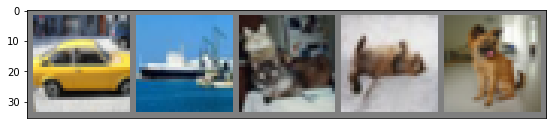


true labels:        car     ship      cat      cat      dog

predictions:        car     ship      cat      cat      dog


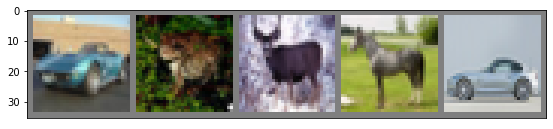


true labels:        car     frog     deer    horse      car

predictions:        car     frog     deer    horse      car


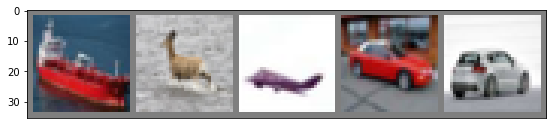


true labels:       ship     deer    plane      car      car

predictions:       ship     bird    plane      car      car


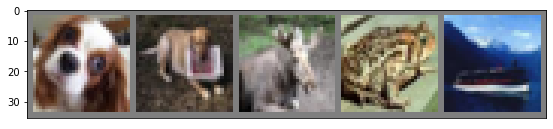


true labels:        dog      dog     deer     frog     ship

predictions:        dog    horse      dog     frog     ship


In [16]:
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(images[:5]))
        print('\ntrue labels: ',
              ''.join('%9s'%classes[labels[j]] 
                       for j in range(5)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=model_ft(images)
        _,preds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%9s'%classes[preds[j]]
                      for j in range(5)))
        if i==3: break

In [17]:
dhtml('Model Training')

In [18]:
num_classes=33; learning_rate=.0007
dataset_sizes={'train':x_train.shape[0],
               'valid':x_valid.shape[0]}
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=tnn.Linear(num_ftrs,num_classes)
model_ft=model_ft.to(dev)
criterion=tnn.CrossEntropyLoss()
optimizer_ft=torch.optim.Adam(model_ft.parameters(),
                              lr=learning_rate)
exp_lr_scheduler=torch.optim.lr_scheduler\
.StepLR(optimizer_ft,step_size=5,gamma=.5)

In [19]:
model_ft=train_model(model_ft,dataloaders2,criterion,
                     optimizer_ft,exp_lr_scheduler,
                     num_epochs=25)

Epoch 1/25
----------
phase: train loss: 2.9067 acc: 0.1940
phase: valid loss: 2.6401 acc: 0.2248
Epoch 2/25
----------
phase: train loss: 1.8875 acc: 0.4423
phase: valid loss: 2.3247 acc: 0.3890
Epoch 3/25
----------
phase: train loss: 1.3753 acc: 0.5859
phase: valid loss: 1.9599 acc: 0.4679
Epoch 4/25
----------
phase: train loss: 0.9686 acc: 0.7075
phase: valid loss: 2.2740 acc: 0.4313
Epoch 5/25
----------
phase: train loss: 0.7432 acc: 0.7699
phase: valid loss: 2.1479 acc: 0.4426
Epoch 6/25
----------
phase: train loss: 0.4037 acc: 0.8769
phase: valid loss: 1.4661 acc: 0.5877
Epoch 7/25
----------
phase: train loss: 0.1930 acc: 0.9471
phase: valid loss: 1.2843 acc: 0.6476
Epoch 8/25
----------
phase: train loss: 0.1007 acc: 0.9769
phase: valid loss: 1.2905 acc: 0.6519
Epoch 9/25
----------
phase: train loss: 0.0554 acc: 0.9890
phase: valid loss: 1.3773 acc: 0.6554
Epoch 10/25
----------
phase: train loss: 0.0388 acc: 0.9937
phase: valid loss: 1.3600 acc: 0.6646
Epoch 11/25
-------

In [20]:
dhtml('Model Evaluation')

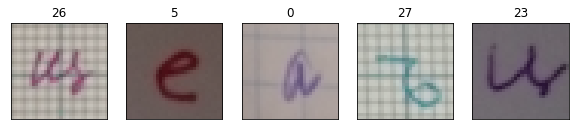


true labels:          щ        е        а        ъ        ц

predictions:          щ        е        н        ъ        ц


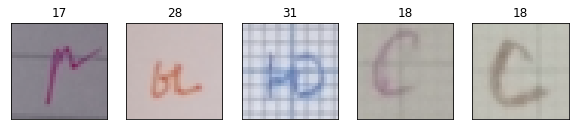


true labels:          р        ы        ю        с        с

predictions:          р        н        ю        с        с


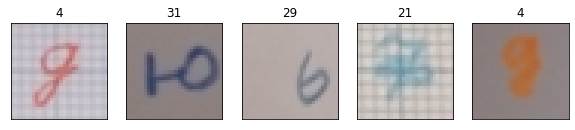


true labels:          д        ю        ь        ф        д

predictions:          д        ю        ы        ф        д


In [21]:
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders2['test']):
        fig=pl.figure(figsize=(10,4))
        for k in range(5):
            ax=fig.add_subplot(1,5,k+1,\
            xticks=[],yticks=[],title=labels[k].item())
            ax.imshow((images[k])\
                      .reshape(img_size,img_size,3))
        pl.show()
        print('\ntrue labels: ',
             ''.join('%9s'%letters[labels[j]]
                      for j in range(5)))
        images=images.to(dev)
        labels=labels.to(dev).long()
        outputs=model_ft(images)
        _,preds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%9s'%letters[preds[j]]
                      for j in range(5)))
        if i==2: break